In [1]:
try:
    import xml.etree.cElementTree as et
except ImportError:
    import xml.etree.ElementTree as et
from bs4 import BeautifulSoup
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import pickle

In [3]:
def getattrib(string):
    """
    {'Id': '5',
     'PostTypeId': '2',
     'ParentId': '1',
     'CreationDate': '2010-11-02T19:15:20.813',
     'Score': '42',
     'OwnerUserId': '13',
     'LastEditorUserId': '75633',
     'LastEditDate': '2017-12-13T08:24:54.477',
     'LastActivityDate': '2017-12-13T08:24:54.477',
     'CommentCount': '0'}
    
    """
    root = et.fromstring(string)
    attr = root.attrib
    attr.pop("Body")
    return attr
infoList = ['PostTypeId','Id','OwnerUserId','CreationDate','AcceptedAnswerId','Tags','ParentId',
            "Score","CommentCount","ViewCount","AnswerCount","FavoriteCount"]
def getinfo(attr):
    tmpList = []
    for key in infoList:
        if key in attr:
            tmp = attr[key]
        else:
            tmp = "null"
        tmpList.append(tmp)
    return tmpList
p1 = re.compile(r'[<](.*?)[>]', re.S)  #最小匹配

In [4]:
path = "../../data/stackoverflow/old/"
fname = path + "Posts.xml"
n=0
nq=0#number of questions 
nqa=0#number of questions with answer
QuestionDict ={}
AnswerDict = {}
start = time.clock()
loss_id = []
data = {key:[] for key in infoList}
with open(fname,'r') as f:
    for line in f:
        if "row" in line:
            n += 1
            attr = getattrib(line)
            tmpList = getinfo(attr)
            PostTypeId, postid,OwnerUserId,datetime,AcceptedAnswerId,tags,ParentId = tmpList[:7]
            if "OwnerUserId" in attr:
                if PostTypeId == '1':#question  
                    nq += 1
                    if 'AcceptedAnswerId' in attr and "Tags" in attr:# Questions that have answers
                        nqa+=1
                        tags = p1.findall(tags)
                        QuestionDict[postid] = (OwnerUserId,AcceptedAnswerId,datetime,tags) 
                elif PostTypeId == '2':#answer
                    if "ParentId" in attr:             
                        AnswerDict[postid]= (OwnerUserId,ParentId,datetime)
                else:
                    pass 
            for key,i in zip(infoList,range(12)):
                data[key].append(tmpList[i])
        if n%100000 == 0:
            elapsed = (time.clock() - start)
            print("===Finish %d   TotalTimeCost %.2f==="%(n,elapsed),end='\r')

In [5]:
print("===Finish %d   TotalTimeCost %.2f==="%(n,elapsed),end='\r')
Data = pd.DataFrame(data)
Data.to_csv ('./Posts_phys.csv', index = None, header=True)

In [21]:
Q = Data[Data.AcceptedAnswerId.notnull()]

In [29]:
start = time.clock()
P = pd.read_csv("./Posts.csv")
elapsed = (time.clock() - start)
print(elapsed)

116.4615289999997


In [ ]:
start = time.clock()
elapsed = (time.clock() - start)

In [35]:
with open("./QuestionDict.pkl",'wb')as f:
    pickle.dump(QuestionDict,f)
with open("./AnswerDict.pkl",'wb')as f:
    pickle.dump(AnswerDict,f)

In [36]:
len(QuestionDict),len(AnswerDict),nq,nqa,nqa/float(nq)

(9187228, 26875245, 17463480, 9187228, 0.5260823157812762)

[Text(0,0,'AcceptedAnswer Rate')]

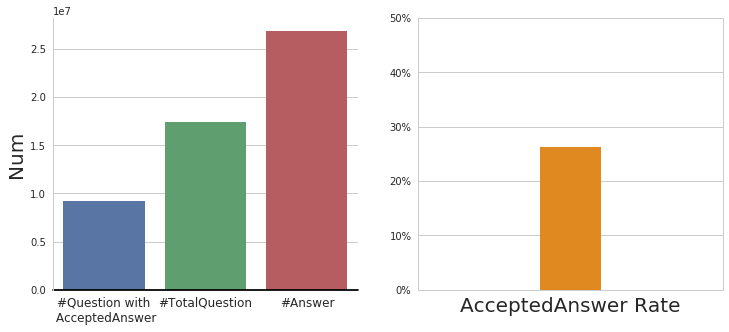

In [82]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,5))
plt.subplot(121)
g = sns.barplot(x=["#Question with\n AcceptedAnswer","#TotalQuestion","#Answer",],y=[len(QuestionDict),nq,len(AnswerDict)])
g.axhline(0, color="k", clip_on=False)
g.set_xticklabels(["#Question with\n AcceptedAnswer","#TotalQuestion","#Answer",],rotation =0,fontsize=12)
sns.despine(bottom=True)
g.set_ylabel("Num",fontsize=20)

plt.subplot(122)
g = sns.barplot(x=["AcceptedAnswer Rate"],y=[nqa/float(nq)],color='darkorange')
g.set_xlim(-2,2)
g.set_yticklabels([str(i*10)+"%" for i in range(11)])
g.set_ylim(0,1)
g.set_xticklabels(["AcceptedAnswer Rate"],fontsize=20)